In [1]:
import torch
import torch.nn as nn
import nltk as nltk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\cunob\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\cunob\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\cunob\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\cunob\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\cunob\AppData\Roaming\nltk_data...
[

True

# Data preprocessing

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
def change_word(sentiment):
    return 1 if sentiment == 'positive' else 0


df['sentiment'] = df['sentiment'].apply(change_word)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


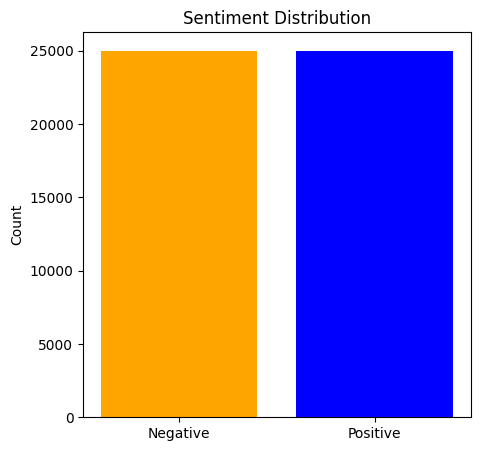

In [4]:
sentiment_counts = df['sentiment'].value_counts()
fig = plt.figure(figsize=(5, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['blue', 'orange'])
plt.title('Sentiment Distribution')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

In [5]:
import re
import nltk
from nltk.corpus import stopwords
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(sentence):
    sentence = re.sub(r'https?:\/\/[^\s]+', '', sentence) # remove URLs
    sentence = re.sub(r'<[^>]+>', '', sentence) # remove html tags
    sentence = re.sub(r'\b\w*\d\w*\b', '', sentence) # remove words that contains digits
    sentence = re.sub(r'\s+', ' ', sentence).strip() # remove whitespaces
    sentence = re.sub(r'\b\d+\b', '', sentence) # remove digits
    sentence = re.sub(r'\s+', ' ', sentence).strip() # remove white spaces
    sentence = re.sub(r'[^\w\s]', '', sentence)
    sentence = re.sub(r'\s+', ' ', sentence).strip() # remove white spaces
    sentence = re.sub(r'[^\w\s]', '', sentence) # remove punctation
    sentence = re.sub(r'\s+', ' ', sentence).strip() # remove white spaces
    sentence = sentence.lower()
    # check stop words
    tokens = []
    for token in sentence.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cunob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cunob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df['review'] = df['review'].apply(clean_text) # remove tags, urls, etc...
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)
print(f"X_train length:{len(X_train)}, \n X_test length: {len(X_test)}")

X_train length:40000, 
 X_test length: 10000


In [8]:
"""TODO Tokenizer plot every word to see what counts add padding
train only on 10000 common word"""
#nltk.download('all')
from nltk.tokenize import word_tokenize

X_train_tokenized = X_train.apply(word_tokenize)
y_train_tokenized = y_train

X_test_tokenized = X_test.apply(word_tokenize)
y_test_tokenized = y_test

# X_train_tokenized = word_tokenize(X_train)
# X_test_tokenized = word_tokenize(X_test)


In [12]:
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch

# Count words in training data
all_words = [word for token in X_train_tokenized for word in token]
word_counts = Counter(all_words)
most_common = word_counts.most_common(10000)

# Create a single word-to-index mapping
word_to_index = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}

# Convert training tokens to indices
X_train_indices = X_train_tokenized.apply(lambda tokens: [word_to_index.get(word, 0) for word in tokens])
X_train_tensors = [torch.tensor(seq) for seq in X_train_indices]
padded_sequences = pad_sequence(X_train_tensors, batch_first=True)

# Create y_train_tensors from y_train
y_train_tensors = torch.tensor(y_train.values).float()  # Convert to float for BCELoss

# Convert test tokens to indices using the same word_to_index
X_test_indices = X_test_tokenized.apply(lambda tokens: [word_to_index.get(word, 0) for word in tokens])
X_test_tensors = [torch.tensor(seq) for seq in X_test_indices]
padded_test_sequences = pad_sequence(X_test_tensors, batch_first=True)

# Create y_test_tensors from y_test
y_test_tensors = torch.tensor(y_test.values).float()  # Convert to float for BCELoss


# Create model and training loop

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  
        
        # Bidirectional LSTM
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers)
        self.dropout_lstm = nn.Dropout(0.2)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
        # Activation function (optional if using BCEWithLogitsLoss)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, lengths):
        # x: (batch_size, seq_len)
        # lengths: list or tensor of sequence lengths before padding

        # Embedding layer
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embedding_dim)
        
        # Move lengths to CPU and convert to LongTensor for pack_padded_sequence
        lengths = lengths.cpu().long()

        # Pack padded sequence to ignore paddings in LSTM
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # First Bidirectional LSTM layer
        packed_output, _ = self.lstm1(packed_input)
        lstm1_out, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        lstm1_out = self.dropout_lstm(lstm1_out)
        
        # Take the output of the last valid time step (before padding)
        batch_size = x.size(0)
        idx = (lengths - 1).view(batch_size, 1, 1).expand(batch_size, 1, lstm1_out.size(2))  # shape: (batch_size, 1, hidden_dim * 2)
        
        # Ensure idx is on the same device as lstm1_out
        idx = idx.to(lstm1_out.device)
        x = lstm1_out.gather(1, idx).squeeze(1)  # Shape: (batch_size, hidden_dim * 2)
        
        # Apply dropout and fully connected layer
        x = self.dropout(x)
        x = self.fc(x)
        
        # Apply sigmoid activation for binary classification
        x = self.sigmoid(x)
        
        return x


# Parameters for the model
vocab_size = len(word_to_index) + 1  # Vocabulary size (including padding)
embedding_dim = 100  # Size of embeddings
hidden_dim = 128  # Hidden state size of LSTM
output_dim = 1  # For binary classification (e.g., sentiment)
num_layers = 2

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
print(model)


SentimentModel(
  (embedding): Embedding(10001, 100)
  (lstm1): LSTM(100, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dropout_lstm): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)


In [14]:
device

device(type='cuda')

In [15]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
train_dataset = TensorDataset(padded_sequences, y_train_tensors)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)


test_dataset = TensorDataset(padded_test_sequences, y_test_tensors)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


In [17]:
epochs = 20
criterion = nn.BCELoss()
clip = 5


padding_token = 0  # Common padding value
history={"train_accuracy":[],"train_loss":[]}
model = model.to(device)
for epoch in range(epochs):
    model.train()
    
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    
    for inputs, labels in train_loader:  # Assuming train_loader yields batches of (inputs, labels)
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()  # Ensure labels have shape (batch_size, 1)

        # Compute sequence lengths (non-padded lengths)
        lengths = (inputs != padding_token).sum(dim=1).cpu().long()  # Properly move lengths to CPU and convert to int64

        optimizer.zero_grad()  # Clear previous gradients
        
        # Forward pass with both inputs and lengths
        outputs = model(inputs, lengths)  # Pass lengths to the model

        # Check for NaN or Inf in model parameters
        # for name, param in model.named_parameters():
        #     if torch.any(torch.isnan(param)) or torch.any(torch.isinf(param)):
        #         print(f"NaN or Inf detected in parameters: {name}")

        # Check if outputs contain NaNs
        # if torch.any(torch.isnan(outputs)):
        #     print("NaN detected in outputs!")
        #     break
        
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5) # clip gradient

        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Compute accuracy
        #preds = torch.round(torch.sigmoid(outputs))  # Assuming you're using BCELoss
        preds = torch.round(outputs)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = correct_predictions / total_samples * 100  # Convert to percentage
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')

    history['train_accuracy'].append(avg_accuracy)
    history['train_loss'].append(avg_loss)


Epoch: 1, Loss: 0.6257, Accuracy: 63.20%
Epoch: 2, Loss: 0.4709, Accuracy: 78.46%
Epoch: 3, Loss: 0.4103, Accuracy: 81.72%
Epoch: 4, Loss: 0.3459, Accuracy: 85.56%
Epoch: 5, Loss: 0.3186, Accuracy: 86.94%
Epoch: 6, Loss: 0.2841, Accuracy: 88.56%
Epoch: 7, Loss: 0.2669, Accuracy: 89.53%
Epoch: 8, Loss: 0.2461, Accuracy: 90.64%
Epoch: 9, Loss: 0.2203, Accuracy: 91.70%
Epoch: 10, Loss: 0.1951, Accuracy: 92.78%
Epoch: 11, Loss: 0.1769, Accuracy: 93.48%
Epoch: 12, Loss: 0.1528, Accuracy: 94.61%
Epoch: 13, Loss: 0.1345, Accuracy: 95.38%
Epoch: 14, Loss: 0.1163, Accuracy: 96.02%
Epoch: 15, Loss: 0.1019, Accuracy: 96.48%
Epoch: 16, Loss: 0.0882, Accuracy: 97.09%
Epoch: 17, Loss: 0.0728, Accuracy: 97.65%
Epoch: 18, Loss: 0.0696, Accuracy: 97.69%
Epoch: 19, Loss: 0.0502, Accuracy: 98.39%
Epoch: 20, Loss: 0.0464, Accuracy: 98.54%


In [18]:
torch.save(model.state_dict(), "lstm_model.pt")


# Plot model accuracy and loss and evaluating model

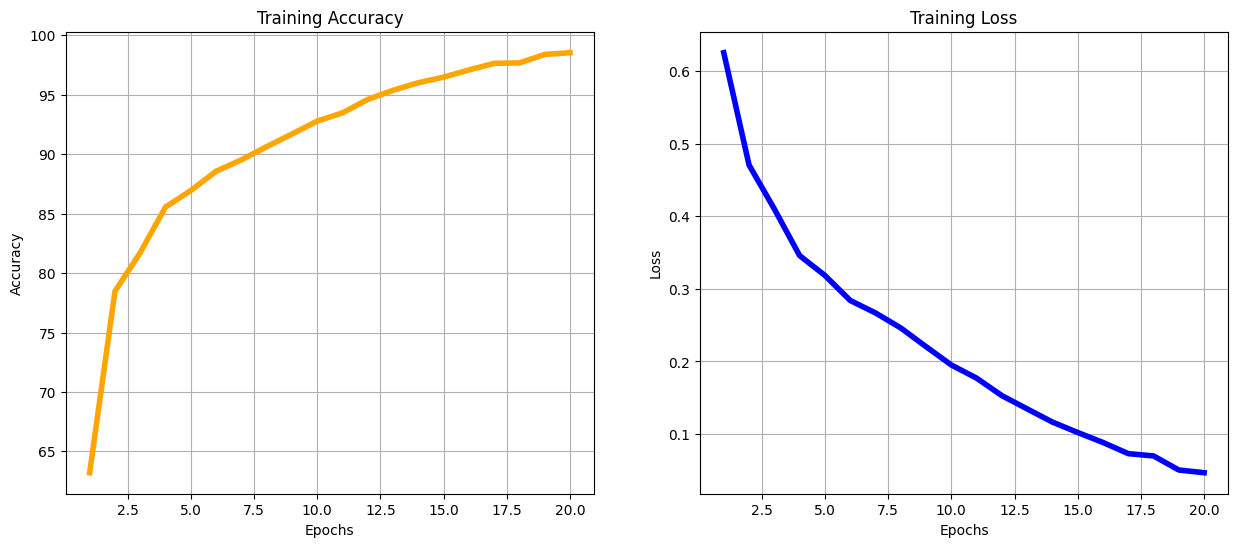

In [30]:
epochs_after_training = range(1, len(history['train_accuracy']) + 1)


fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# ACCURACY
axs[0].plot(epochs_after_training, history["train_accuracy"], color="orange", linewidth=4)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Training Accuracy")
axs[0].grid(True)

# LOSS
axs[1].plot(epochs_after_training, history["train_loss"], color="blue", linewidth=4)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Training Loss")
axs[1].grid(True)

plt.show()


In [31]:


model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct_predictions = 0
total_samples = 0

criterion = nn.BCELoss()

with torch.no_grad():  # Disable gradient calculations
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()
        
        # Compute sequence lengths (if needed)
        lengths = (inputs != padding_token).sum(dim=1).cpu().long()

        # Forward pass: get predictions
        outputs = model(inputs, lengths)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        preds = torch.round(outputs)  # For binary classification
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_samples * 100

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.6520, Test Accuracy: 84.75%
